# Grade: /100 pts

# Assignment 04: Confidence Intervals & The Bootstrap

Once you are finished, ensure to complete the following steps.
1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.
2.  Fix any errors which result from this.
3.  Repeat steps 1. and 2. until your notebook runs without errors.
4.  Submit your completed notebook to OWL by the deadline.

In [6]:
# Add the necessary imports for this homework 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection
import sklearn.linear_model
from scipy.stats import t

### Question 1: /10pts 
In this question, you will construct a confidence interval for the sample mean, not using the normal distribution, but the t-distribution (see end of lecture 4.3), which is more accurate for small sample sizes.  

The $100(1-\alpha)\%$ confidence interval is 

$$ \bar{x} \pm  t_{1-\alpha/2, n-1} \dfrac{\hat{\sigma}}{\sqrt{n}} $$

Where $ t_{1-\alpha/2, n-1}$ is the appropiorate quantile of a Student's t distribution with $n-1$ degrees of freedom.  
Write a function called `confidence_interval` which takes as it's argument an array of data called `data` and returns two things:

* An estimated mean of `data`, and 

* The lower and upper bounds of the 95% confidence interval for the mean of `data`.  Ensure these are returned in a numpy array of shape (2,)

To get the appropirate quantiles for the t-distribution, you can use `scipy.stats.t`, which implements some statistical functions for the t-distribution.  Take a look at the documentation for `scipy.stats.t`, especially the `ppf` method.

Here is the documentation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html


In [7]:
def confidence_interval(data):

    estimated_mean = data.mean()
    n = len(data)
    tval = t.ppf(0.975, df = n-1)
    se = np.std(data, ddof = 1)
    margin = tval * se/np.sqrt(n)
    bounds = [estimated_mean - margin, estimated_mean + margin]
    
    return estimated_mean, bounds

### Question 2: /15pts

The "95% confidence interval" is named so because the long term relative frequency of these estimators containing the true estimand is 95%.  That is to say **if I construct 100 95% confidence intervals for the sample mean again and again from the same data generating mechanism, 95 of these intervals I construct will contain the true population mean**.

Write a function called `ci_simulation` that runs some simulations to show this is the case.  From a standard normal distribution, sample 25 observations and construct a confidence interval.  Do this 20 times and plot the intervals using `matplotlib.pyplot.errorbar`.  Color the bar red if the confidence interval does not capture the true mean and blue if it does.  If you are unfamilliar with `matplotlib.pyplot.errorbar`, I highly suggest reading Matplotlib's excellent documentation which has some examples at the bottom of the webpage.

If you are unfamilliar with how to sample random numbers, I suggest you look at `numpy.random.normal`.  Try searching for the documentation for that function yourself if you need to.

Here is the documentation for `matplotlib.pyplot.errorbar`: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html

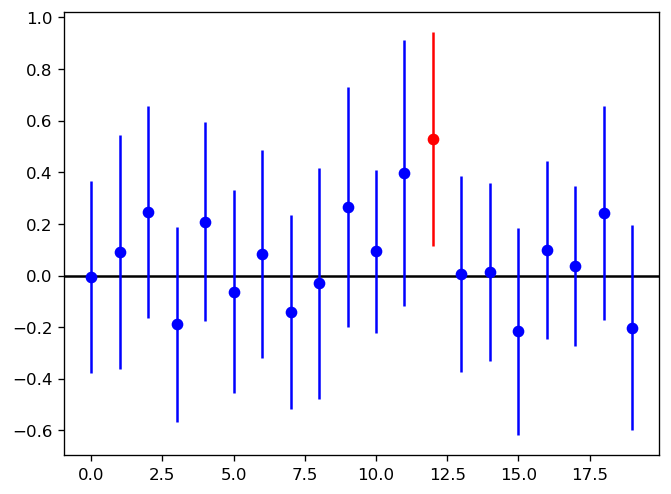

In [79]:
def ci_simulation():
    # Set the random seed to always get the same random numbers. 
    # This is for Reproducibility. 
    np.random.seed(4)
    
    # Create the figure.
    fig, ax = plt.subplots(dpi = 120)

    # If the interval crosses this line, it should be blue, else red.
    ax.axhline(0, color = 'k')

    # Do the following 20 times
    for i in range(20):

        #Draw 25 observations from a standard normal
        data = np.random.normal(size = 25)
        
        # Compute what we need for the CI, namely the mean and the bounds
        mu, bounds = confidence_interval(data)
        
        # color should be blue if it crosses the black line
        color = 'blue'
        if (min(bounds)>0)|(max(bounds)<0):
            # but in the case it does not, turn it red
            color = 'red'

        # Need to get the length of the interval from bounds
        interval_len = 1.0/2*(bounds[1] - bounds[0])
        ax.errorbar(i, mu, yerr=interval_len, color = color, fmt = 'o')

    # This function does not have to return anything
    return None

ci_simulation()

### Question 3: /8pts

If you haven't changed the random seed from 4 and if you implemented the solution correctly, you should see one red interval.

Answer the following below in no more than 3 sentences:

a) How many red intervals did we expect to see?  What is your justifiation for this?

Changing the random seed might affect how many red intervals you see.  Try changing the  random seed in your function to 3.  This will yield two red intervals (which is different than what you should expect to see). 

b) Why does the simulation sometimes deviate from the predicted results?


a) **We would expect to see that 95% of the time, we will get intervals that fall within our predicted range because we are only performing the confidence interval with a 95% confidence. This means that we are only confident that 95% of the time our predicted range will be true**

b) **The simulation sometimes deviates because we are getting random samples, and each sample will have a different variability - thus, some sampels will produce more or less confidence intervals that fall out of the range.** 

### Question 4: /10pts

Load in the `hockey_draftees_2005.csv` data into pandas. It contains data from hockey players drafted in 2005, including their rank, weight (wt - in pounds) and height (ht - in inches). 

Fit a linear model of weight (`wt`) explained by height (`ht`) using a linear regression model from sklearn, as done in the lab (but with linear fit instead of cubic.)  Call your fitted model `model`.  
Make a scatter plot of the height (x-axis) against weight (y-axis). 
Add the predicted values for 66-80 inches. 

Calculate the residuals from the fit, and report the r-squared for this model.

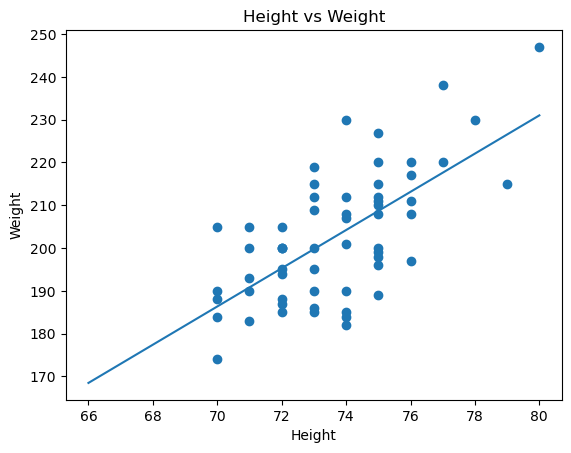

In [40]:
df = pd.read_csv('hockey_draftees_2005.csv')
X_fit = np.c_[df.ht]
x = df['ht']
y = df['wt']

# Make linear regression object and fit the model 
model = sklearn.linear_model.LinearRegression()
model.fit(X_fit, y)

n = len(y)
p_ht = np.linspace(66.0, 80.0, n)
X_pred = np.c_[p_ht]
p_weight = model.predict(X_pred)

# Make the scatter plot 
plt.scatter(x, y)
plt.title("Height vs Weight")
plt.xlabel("Height")
plt.ylabel("Weight")

# Add the line to the graph
plt.plot(p_ht, p_weight)

In [24]:
# Calculate residuals, R2 and print it
model.rsquared  = model.score(X_fit, y)
print('Training rsquared is ', model.rsquared)

Training rsquared is  0.43807746842392203


### Question 5:  /15pts
### Bootstrap confidence intervals on parameters

How confident can we be about the relation between height and weight? 
To judge this we need confidence intervals. Let's use the bootstrap.

Modify the function `BootstrapCoef` from lab 04 - part 2 to conduct a boostrap analysis for this regression mode; 

* `data`, which is a dataframe having columns 'weight' and 'height'
* `numboot` which is an integer denoting how many bootstrap replications to perform.

Write `bootstrap` to perform bootstrap resampling. You can use `pd.DataFrame.sample` with `replace = True` to perform the resampling.  `bootstrap` should return:
params: a numpy array of size [numboot,numParams] of bootstraped parameter values. The parameters are the intercept value and the slope from the linear regression. 
Tip: Note that the intercept can be retrieved from model.intercept_, whereas all the other regression coefficients are stored in model.coef_. 

Here is the documentation for `pd.DataFrame.sample`: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html

Then call the function to get 100 bootstrap samples for your linear regression model of wt explained by height. 
Make a joint scatter plot of the parameter value for the intercept and for the slope. 

In [71]:
# Write a Bootstrap function that records the fitted models 
def BootstrapCoef(data,numboot = 1000):
    n = len(data)
    numParams  = np.zeros((numboot, 2))

    for i in range(numboot):
        d = data.sample(n, replace=True)
        X_fit = np.c_[d.ht]
        model.fit(X_fit, d.wt)
        numParams[i] = model.intercept_, model.coef_
    
    return numParams

/var/folders/y1/j9vn1g2x5cv59h65drydqnk80000gn/T/ipykernel_5686/970965014.py:11: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  numParams[i] = model.intercept_, model.coef_
/var/folders/y1/j9vn1g2x5cv59h65drydqnk80000gn/T/ipykernel_5686/970965014.py:11: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  numParams[i] = model.intercept_, model.coef_
/var/folders/y1/j9vn1g2x5cv59h65drydqnk80000gn/T/ipykernel_5686/970965014.py:11: DeprecationWarning: setting an array element with a sequence. This was supported in s

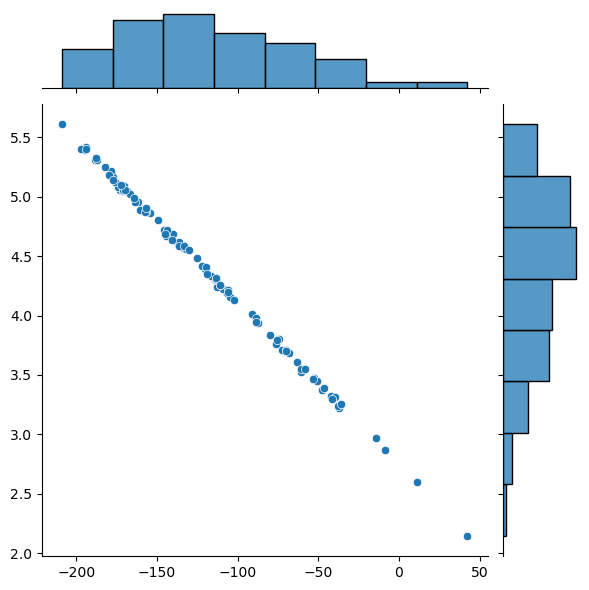

In [72]:
thetaBS = BootstrapCoef(df, 100)

# Plotting the joint scatterplot
sns.jointplot(x = thetaBS[:,0], y = thetaBS[:,1])

### Question 6: /12pts

Plot the bootstrap estimates for the slope as a histogram.  Use your samples to compute a 95% confidence interval. Note that the CI should be constructed around the sample estimate of the slope. How can you interpret this confindence interval?  

In [74]:
# Calculate bootstrap interval
boot_ci = (np.quantile(thetaBS[:,1], 0.025), np.quantile(thetaBS[:,1], 0.975))

print('My confidence interval is between', boot_ci[0], ' and ', boot_ci[1])

My confidence interval is between 2.916692742480263  and  5.402457209084388


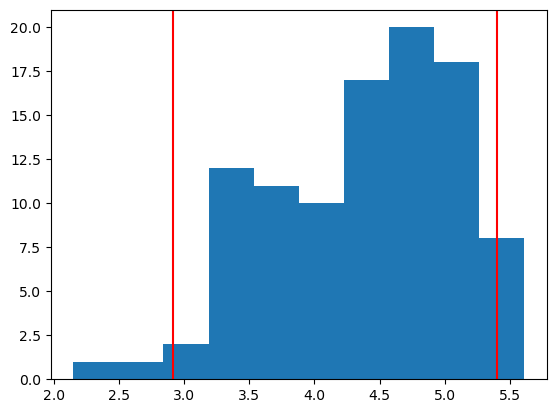

In [75]:
# Plotting boostrap estimates for slope as histogram
plt.hist(thetaBS[:,1])
plt.axvline(x = boot_ci[0], color = 'red')
plt.axvline(x = boot_ci[1], color = 'red')

Written answer: 
This means that the true slope parameter will fall within this interval with a 95% probability.

### Question 7: /15pts
Modify the function `BootstrapPred` from lab04 to bootstrap your fit and generate a predict from each of these bootstrapped models.  

Draw again a scatter plot of ht against weight. and plot the predictions from the 20 fitted bootstrap models to derive predictions for the height ranging from 66 to 80. Draw all these lines onto your scatter plot. 

Written question: Where are we most uncertain in our prediction about the weight of a player? How does the negative correlation between slope and intercept play a role here?  Why is the spread of the prediction in the mean weight so much lower than the variability of our intercept parameter? 

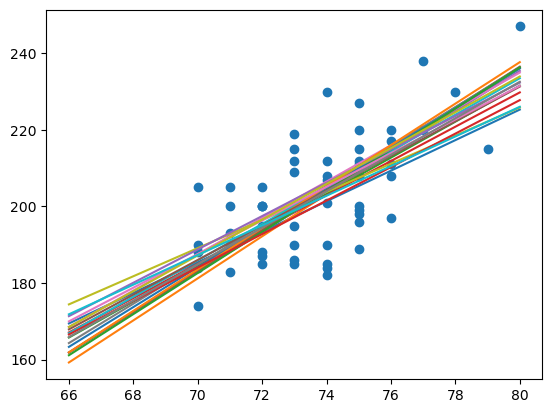

In [76]:
# Write a Bootstrap function that records the fitted models
def BootstrapPred(data, xp, numboot = 1000):
    n = len(data)
    X_pred = np.c_[xp]
    y_pred = np.zeros((numboot,X_pred.shape[0]))    

    for i in range(numboot):
        d = data.sample(n, replace=True)
        X_fit = np.c_[d.ht]
        model.fit(X_fit, d.wt)
        y_pred[i,:] = model.predict(X_pred)
        
    return y_pred

p_ht = np.linspace(66.0, 80.0, 20)

# Get predictions from 20 bootstrapped models 
y_pred = BootstrapPred(df, p_ht)

plt.scatter(df.ht, df.wt)
# Make a scatterplot and draw the 20 lines  
for i in range(20):
    plt.plot(p_ht, y_pred[i,:])

**We are most unsure of our solutions when the height is less than 70 because we have not trained our model with values below 70. Additionally, we observe a positive correlation here, where as the height increases, so does their weight. As well, the spread of the prediction of the mean weight is lower because this is where we observe most of the data -  thus, the constraints are tighter because we have more infromation to train the model around these points.**

### Question 8:  /15pts

Now, let's see how well our model performs out of sample.  Load in the `hockey_draftees_test.csv` file into a dataframe.  
Use your fitted `model` to make predictions. 

Make a scatter plot of the test data and superimpose the prediction of the model. 
To evaluate this prediction, calculate the r-squared value for the out of sample (oos) data.  Statsmodels doesn't provide a function to compute r-squared on new data.  You will have to write one yourself or find one that performs the computation for you.

In [53]:
df_test = pd.read_csv('hockey_draftees_test.csv')

# Generate and plot the predicted values
p_ht = np.linspace(min(df_test.ht), max(df_test.ht), len(df_test.ht))

X_pred = np.c_[p_ht]
p_weight = model.predict(X_pred)

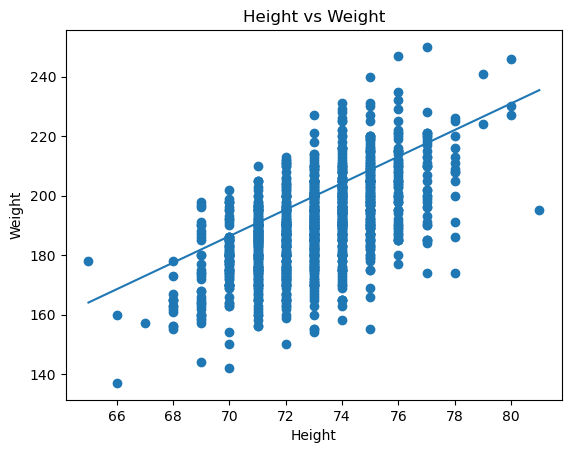

In [54]:
# Make the scatter plot 
plt.scatter(df_test.ht, df_test.wt)
plt.title("Height vs Weight")
plt.xlabel("Height")
plt.ylabel("Weight")

# Add the line to the graph
plt.plot(p_ht, p_weight)

# -0.015

In [80]:
rsq = model.score(np.c_[df_test.ht], df_test.wt)
print('rsquared our of sample is ', rsq)

rsquared our of sample is  -0.20762516064452075
